## NLP With Recurrent Neural Networks

_Recurrent Neural Networks_ take the sequence of data into account when its learning. In the case of the classifier for text that we did before, the order the words appear in the sentence doesn't really matter. What determined the sentiment was the vector that resulted in adding up all of the individual vectors. 

To generate text the order does matter. For example:

_'Today the weather is gorgeous and I see a beautiful...'


You would predict the next words to be _'blue sky'_ as the context of the sentence is the _'weather'_ that we saw earlier in the sentence. How can this be fit to neural networks?

Changing from sequence list data to sequential data. 

????Recurrent neural networks???? - Recurrence of Data

Sequence can be strong but weakens as the context spreads, value input at neuron 0 will have little impact at neuron 100. RNN's have a very short term memory. Consider another example:

_'I lived in Ireland, so at school they made me learn how to speak...'_

The answer is _'Gaelic'_ but the word that gave this context was much earlier in the sentence. If we are only using words close to the desired one then we'd miss this context and get a bad prediction.

Key here is to use a Long Short Term Memory Recurrent Neural Network, LTSM RNN. 

 ### LSTM RNN
 
So how do we manage the understanding of context in language across longer sentences? LSTM architecture introduces the concept of a cell state, which is a context that can be maintained across many timestamps. Can be bi-directional, later words in the sentence can provide context to earlier ones.

### Implementing in Code

Using our sarcasm classifier as before, we define in the sequential neural network a layer to be LSTM. If we want it to be bi-directional we wrap the LSTM layer in the bi-directional layer. (might not be best for every scenario)

For example:

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

def model(tokenizer, vocab_size):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
        #define we want an LSTM style layer
        #takes parameter for hidden number of nodes (here is 64)
        #this is also the dimensionality of the output
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), 
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model
#note that dimensionalities of layers are same as previous 
#with the exception of the sigmoid activation layer

Can also stack LSTM layers the same way you stack Dense layers so the outputs of one layer get fed into the next layer, make sure return sequences is set to True for all but your last layer:

In [2]:
def model_stacked(tokenizer, vocab_size):
    model_stacked = tf.keras.Sequential([
        tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Biderectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model_stacked

LSTM layers give a large number of parameters for the neural network to operate with. 

## Generating Text
#### Training an AI to Create Poetry

Using LSTM layers in a RNN we can account for context that appeared a long time ago. Here we are using txt file of irish poems to create an irish poem ourselves. This set of literature has a very distincitve style. There are subtle differences when generating text and classifying text. For example, we don't encode with an OOV. When generating text we don't need a validation data set. So if we tokenize the entire corpus there won't be any future out of vocabulary tokens to account for. We use every bit of data we have to spot patterns of where and how words occur. 

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [4]:
#initialize tokenizer
tokenizer = Tokenizer()

#read in text file
data = open(r"C:\Users\khick\Documents\irish-lyrics-eof.txt").read()

#text fiile is stored as a string with /n separating the lines
#can be broken into separate sentences by splitting into separate strings @ /n
corpus = data.lower().split("\n")

#fit tokeinzer to corpus to get a word index
tokenizer.fit_on_texts(corpus)
#+1 is to include the OOV 
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

Now we have a list of sentences that are tokenized we can turn them to a set of training data. 

When we tokenize a line we get a list of numbers. We can split this list further to have the first two numbers, the first three, the first four etc... For example:

In [5]:
#example tokenized list
tokenized_list = [12, 45, 67, 8, 35, 80]

#example input sequences
sequence1 = [12, 45]
sequence2 = [12, 45, 67]
sequence3 = [12, 45, 67, 8]
sequence4 = [12, 45, 67, 8, 35]
sequence5 = [12, 45, 67, 8, 35, 80]

This is so we can train the model to predict what comes after: this word, these two words, these three words, etc... 

In [6]:
#intialize empty list of input sequences 
input_sequences = []
#iterate through each line in the corpus and create a list of tokens 
#note: not list of tokens for WHOLE corpus
for line in corpus:
    #text to sequence per line
    token_list = tokenizer.texts_to_sequences([line])[0]
    #generate n-grams
    #iterate through first two indexes to end of indexes
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# have multiple lists, each sentence needs to be padded 
max_sequence_len = max([len(x) for x in input_sequences])

#this will pad the n-gram sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
#we convert to numpy array for tensorflow 2.x
input_sequences = np.array(input_sequences)

 For the computer to read n-grams as a input and label (x and y) we must slice the list. For example, take sequence2 from before (note the padding before):

In [7]:
padded_sequence2 = [0, 0, 0, 12, 45, 67]

Our inputs would be everything but the final value, so our x input would be: (0,0,0,12,45) and the y: (67). We want the program to learn when it receives this input sequence that the net number should be 67. 

We do this by slicing the lists appropriately. We want the ys to be categorical and one hot encoded so when trained we will be able to predict all of the words in our corpus which one is most likely to be next in the sequence given the current set of words. 

_Categoricals_ are a datatype corresponding to categorical variables in statistics: A categorical variable takes on a limited, and usually fixed, number of possible value. For example: gender, social, class, blood-type, etc...

In [8]:
# create predictors and label (x and y) by slicing
#xs are whole list except final index
#labels are only the final indes
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

#input is our labels (final index in slice)
#num_classes we define as number of words (tokens) in our corpus
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

To illustrate one hot encoding we will take padded_sequence3 from before. Shown is the x (input), y (label) and Y (one hot encoded):

In [9]:
padded_sequence3 = [0, 0, 12, 45, 67, 8]
x_sequence3 = [0, 0, 12, 45, 67]
label_sequence3 = [8]
#below is vector of whole corpus where token 8 is the one hot encoded index 
#and the rest are zeros
Y_sequence3 = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0,]

For further illustration, arbitrarily printing strings to show their tokens.

In [10]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

8
1
71
6
713
39
1790
1791


And now printing an input and its label with the OHE vector:

In [11]:
print(xs[5])
print(ys[5])

[   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
[0. 0. 0. ... 0. 0. 0.]


Now we have features and labels we can train a NN.
### Training the Neural Network

Creating a sequential neural network, similar as before, with LSTM layers.

_Pseudocode_ for layer is as follows:
- Initialize sequential network
- Add first layer, embedding layer: input length has -1 as final value in each sequence was removed to be the label
- Add LSTM layer, here we use a bidirectional layer
- add activation layer, output dimensioanlity is length of corpus. Labels are one hot encoded so should have an output that is representative of this 
- Choose an optimzer, Adam ia a default optimizer
- Compile netwrok with appropriate loss function. Categorical cross entropy used as our labels are categorical with a large number of classes
- Fit model with data

In [12]:
#initialize sequential network
RNN_model = Sequential()

#add layers
RNN_model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
RNN_model.add(Bidirectional(LSTM(150))) 
RNN_model.add(Dense(total_words, activation='softmax'))

#add optimizer
adam = Adam(learning_rate=0.01)
#compile with loss function
RNN_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

RNN_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           269000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2690)              809690    
                                                                 
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


Recommended to use large number of epochs, initial accuracy is very low. Using an extremely unstructured dataset, so network is trying to figure out rules match xs to ys.

In [13]:
history = RNN_model.fit(xs, ys, epochs=30, verbose=1)
print(RNN_model)

Epoch 1/30
377/377 [==============================] - 12s 24ms/step - loss: 6.6682 - accuracy: 0.0717
Epoch 2/30
377/377 [==============================] - 9s 25ms/step - loss: 5.7845 - accuracy: 0.1142
Epoch 3/30
377/377 [==============================] - 10s 27ms/step - loss: 4.9618 - accuracy: 0.1564
Epoch 4/30
377/377 [==============================] - 11s 30ms/step - loss: 4.1093 - accuracy: 0.2194
Epoch 5/30
377/377 [==============================] - 11s 29ms/step - loss: 5.0639 - accuracy: 0.2047
Epoch 6/30
377/377 [==============================] - 11s 28ms/step - loss: 2.9176 - accuracy: 0.3721
Epoch 7/30
377/377 [==============================] - 10s 28ms/step - loss: 2.1636 - accuracy: 0.5033
Epoch 8/30
377/377 [==============================] - 10s 28ms/step - loss: 1.7469 - accuracy: 0.5881
Epoch 9/30
377/377 [==============================] - 11s 29ms/step - loss: 1.4554 - accuracy: 0.6519
Epoch 10/30
377/377 [==============================] - 11s 30ms/step - loss: 1.2613

Now we have a model we can pass it a sequence and it will give us the predicted next value. To generate poetry we can:
- Pass a sequence and predict next value
- Add this sequence to the previous one
- Pass this new sequence and repeat the process
#### Visualising the Accuracy

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

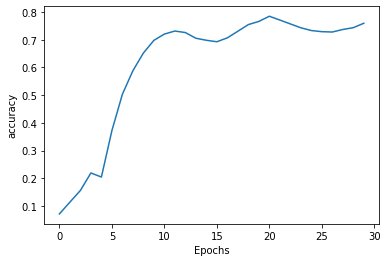

In [15]:
plot_graphs(history, 'accuracy')

To get our model to generate some text we can seed it with some words and predict the next value.

### Generating the Poem

In [16]:
seed_text = "On the pale Moon"
next_words = 100
  
for _ in range(next_words):
    #begin with the first token in the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    #pad the sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #use the model to predict the next word
    predicted = np.argmax(RNN_model.predict(token_list), axis=-1)
    #define as string
    output_word = ""
    
    for word, index in tokenizer.word_index.items():
        #predicted word is next word to add
        if index == predicted:
            output_word = word
            break
            #add word to current string of words with a space between
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 23ms/step
On the pale Moon above the thorn tree to take he can now forty three lassie of love or how love of love he knows love a man love my love forever my love into now in carrigfergus or say for a thou art turns able to love any runaway and ill love and she said me that at lanigans ball or a bath men of love them down all come from strife and the same look stop and they steal bloom back behind in fray assembled free invitation bragh lie of ballyjamesduff times i spent that love or writin a drop of pure


This peom is not very good! We only trained on a limited data set where certain words appear more often in sequences (for example, Love). Nonetheless this demonstrates the architecture of LSTM Recurrent Neural Networks and their application in natural language processing.